In [1]:
import argparse
import gym
import gymfc
import numpy as np
from mpi4py import MPI
from collections import OrderedDict
import math
import os
import time
import matplotlib.pyplot as plt



import nest_asyncio
nest_asyncio.apply()

In [2]:
def plot_step_response(desired, actual,
                 end=1., title=None,
                 step_size=0.001, threshold_percent=0.1):
    """
        Args:
            threshold (float): Percent of the start error
    """

    #actual = actual[:,:end,:]
    end_time = len(desired) * step_size
    t = np.arange(0, end_time, step_size)

    #desired = desired[:end]
    threshold = threshold_percent * desired

    plot_min = -math.radians(350)
    plot_max = math.radians(350)

    subplot_index = 3
    num_subplots = 3

    f, ax = plt.subplots(num_subplots, sharex=True, sharey=False)
    f.set_size_inches(10, 5)
    if title:
        plt.suptitle(title)
    ax[0].set_xlim([0, end_time])
    res_linewidth = 2
    linestyles = ["c", "m", "b", "g"]
    reflinestyle = "k--"
    error_linestyle = "r--"

    # Always
    ax[0].set_ylabel("Roll (rad/s)")
    ax[1].set_ylabel("Pitch (rad/s)")
    ax[2].set_ylabel("Yaw (rad/s)")

    ax[-1].set_xlabel("Time (s)")


    """ ROLL """
    # Highlight the starting x axis
    ax[0].axhline(0, color="#AAAAAA")
    ax[0].plot(t, desired[:,0], reflinestyle)
    ax[0].plot(t, desired[:,0] -  threshold[:,0] , error_linestyle, alpha=0.5)
    ax[0].plot(t, desired[:,0] +  threshold[:,0] , error_linestyle, alpha=0.5)
 
    r = actual[:,0]
    ax[0].plot(t[:len(r)], r, linewidth=res_linewidth)

    ax[0].grid(True)



    """ PITCH """

    ax[1].axhline(0, color="#AAAAAA")
    ax[1].plot(t, desired[:,1], reflinestyle)
    ax[1].plot(t, desired[:,1] -  threshold[:,1] , error_linestyle, alpha=0.5)
    ax[1].plot(t, desired[:,1] +  threshold[:,1] , error_linestyle, alpha=0.5)
    p = actual[:,1]
    ax[1].plot(t[:len(p)],p, linewidth=res_linewidth)
    ax[1].grid(True)


    """ YAW """
    ax[2].axhline(0, color="#AAAAAA")
    ax[2].plot(t, desired[:,2], reflinestyle)
    ax[2].plot(t, desired[:,2] -  threshold[:,2] , error_linestyle, alpha=0.5)
    ax[2].plot(t, desired[:,2] +  threshold[:,2] , error_linestyle, alpha=0.5)
    y = actual[:,2]
    ax[2].plot(t[:len(y)],y , linewidth=res_linewidth)
    ax[2].grid(True)

    plt.show()

In [3]:
current_dir = os.getcwd()
print(current_dir)
config_path = os.path.join(current_dir,
                               "../configs/iris.config")
print(config_path)
os.environ["GYMFC_CONFIG"] = config_path

/home/ec2-user/nti/experiments_bezvershenko/controllers
/home/ec2-user/nti/experiments_bezvershenko/controllers/../configs/iris.config


In [42]:
import argparse
import gym
import gymfc
import numpy as np
from mpi4py import MPI
import math
import os
import time

class Policy(object):
    def action(self, state, sim_time=0, desired=np.zeros(3), actual=np.zeros(3)):
        pass

    def reset(self):
        pass


class Agent(Policy):
    def __init__(self):
        self.r = [39, 6, 0]
        self.p = [35, 8, 0]
        self.y = [6, 35, 0]
        self.controller = PIDController(pid_roll=self.r, pid_pitch=self.p, pid_yaw=self.y)

    def predict(self, state, sim_time=0, desired=np.zeros(3), actual=np.zeros(3)):
        # Convert to degrees
        desired = list(map(math.degrees, desired))
        actual = list(map(math.degrees, actual))
        motor_values = np.array(self.controller.calculate_motor_values(sim_time, desired, actual))
        # Need to scale from 1000-2000 to -1:1
        return np.array([(m - 1000) / 500 - 1 for m in motor_values])

    def reset(self):
        self.controller = PIDController(pid_roll=self.r, pid_pitch=self.p, pid_yaw=self.y)
        


class PIDController(object):
    FD_ROLL = 0
    FD_PITCH = 1
    FD_YAW = 2
    PTERM_SCALE = 0.12029
    ITERM_SCALE = 0.194381
    DTERM_SCALE = 0.000529
    minthrottle = 1070
    maxthrottle = 2000

    def __init__(self, pid_roll=[40, 40, 30], pid_pitch=[58, 50, 35], pid_yaw=[80, 45, 20], itermLimit=150):

        # init gains and scale
        self.Kp = [pid_roll[0], pid_pitch[0], pid_yaw[0]]
        self.Kp = [self.PTERM_SCALE * p for p in self.Kp]

        self.Ki = [pid_roll[1], pid_pitch[1], pid_yaw[1]]
        self.Ki = [self.ITERM_SCALE * i for i in self.Ki]

        self.Kd = [pid_roll[2], pid_pitch[2], pid_yaw[2]]
        self.Kd = [self.DTERM_SCALE * d for d in self.Kd]

        self.itermLimit = itermLimit

        self.previousRateError = [0] * 3
        self.previousTime = 0
        self.previous_motor_values = [self.minthrottle] * 4
        self.pid_rpy = [PID(*pid_roll), PID(*pid_pitch), PID(*pid_yaw)]

    def calculate_motor_values(self, current_time, sp_rates, gyro_rates):
        rpy_sums = []
        for i in range(3):
            self.pid_rpy[i].SetPoint = sp_rates[i]
            self.pid_rpy[i].update(current_time, gyro_rates[i])
            rpy_sums.append(self.pid_rpy[i].output)
        return self.mix(*rpy_sums)

    def constrainf(self, amt, low, high):
        # From BF src/main/common/maths.h
        if amt < low:
            return low
        elif amt > high:
            return high
        else:
            return amt

    def mix(self, r, p, y):
        PID_MIXER_SCALING = 1000.0
        pidSumLimit = 10000.  # 500
        pidSumLimitYaw = 100000.  # 1000.0#400
        motorOutputMixSign = 1
        motorOutputRange = self.maxthrottle - self.minthrottle  # throttle max - throttle min
        motorOutputMin = self.minthrottle

        currentMixer = [
            [1.0, -1.0, 0.598, -1.0],  # REAR_R
            [1.0, -0.927, -0.598, 1.0],  # RONT_R
            [1.0, 1.0, 0.598, 1.0],  # REAR_L
            [1.0, 0.927, -0.598, -1.0],  # RONT_L
        ]
        mixer_index_throttle = 0
        mixer_index_roll = 1
        mixer_index_pitch = 2
        mixer_index_yaw = 3

        scaledAxisPidRoll = self.constrainf(r, -pidSumLimit, pidSumLimit) / PID_MIXER_SCALING
        scaledAxisPidPitch = self.constrainf(p, -pidSumLimit, pidSumLimit) / PID_MIXER_SCALING
        scaledAxisPidYaw = self.constrainf(y, -pidSumLimitYaw, pidSumLimitYaw) / PID_MIXER_SCALING
        scaledAxisPidYaw = -scaledAxisPidYaw

        # Find roll/pitch/yaw desired output
        motor_count = 4
        motorMix = [0] * motor_count
        motorMixMax = 0
        motorMixMin = 0
        # No additional throttle, in air mode
        throttle = 0
        motorRangeMin = 1000
        motorRangeMax = 2000

        for i in range(motor_count):
            mix = (scaledAxisPidRoll * currentMixer[i][1] +
                   scaledAxisPidPitch * currentMixer[i][2] +
                   scaledAxisPidYaw * currentMixer[i][3])

            if mix > motorMixMax:
                motorMixMax = mix
            elif mix < motorMixMin:
                motorMixMin = mix
            motorMix[i] = mix

        motorMixRange = motorMixMax - motorMixMin
        # print("range=", motorMixRange)

        if motorMixRange > 1.0:
            for i in range(motor_count):
                motorMix[i] /= motorMixRange
            # Get the maximum correction by setting offset to center when airmode enabled
            throttle = 0.3

        else:
            # Only automatically adjust throttle when airmode enabled. Airmode logic is always active on high throttle
            throttleLimitOffset = motorMixRange / 2.0
            throttle = self.constrainf(throttle, 0.0 + throttleLimitOffset, 1.0 - throttleLimitOffset)

        motor = []
        for i in range(motor_count):
            motorOutput = motorOutputMin + (motorOutputRange * (
                    motorOutputMixSign * motorMix[i] + throttle * currentMixer[i][mixer_index_throttle]))
            motorOutput = self.constrainf(motorOutput, motorRangeMin, motorRangeMax);
            motor.append(motorOutput)

        motor = list(map(int, np.round(motor)))
        return motor

    def is_airmode_active(self):
        return True

    def reset(self):
        for pid in self.pid_rpy:
            pid.clear()
    
class PID:
    """PID Controller
    """

    def __init__(self, P=1.2, I=1, D=0.001):

        self.Kp = P
        self.Ki = I
        self.Kd = D

        self.sample_time = 0.00
        self.current_time = 0
        self.last_time = self.current_time

        self.clear()

    def clear(self):
        """Clears PID computations and coefficients"""
        self.SetPoint = 0.0

        self.PTerm = 0.0
        self.ITerm = 0.0
        self.DTerm = 0.0
        self.last_error = 0.0

        # Windup Guard
        self.int_error = 0.0
        self.windup_guard = 13.0

        self.output = 0.0

    def update(self, current_time, feedback_value):
        """Calculates PID value for given reference feedback

        .. math::
            u(t) = K_p e(t) + K_i \int_{0}^{t} e(t)dt + K_d {de}/{dt}

        .. figure:: images/pid_1.png
           :align:   center

           Test PID with Kp=1.2, Ki=1, Kd=0.001 (test_pid.py)

        """
        error = self.SetPoint - feedback_value

        delta_time = (current_time - self.last_time) / current_time
        delta_error = (error - self.last_error) / error

        if (delta_time >= self.sample_time):
            self.PTerm = self.Kp * error
            self.ITerm += error * delta_time

            if (self.ITerm < -self.windup_guard):
                self.ITerm = -self.windup_guard
            elif (self.ITerm > self.windup_guard):
                self.ITerm = self.windup_guard

            self.DTerm = 0.0
            if delta_time > 0:
                self.DTerm = delta_error / delta_time

            # Remember last time and last error for next calculation
            self.last_time = current_time
            self.last_error = error

            # print("P=", self.PTerm, " I=", self.ITerm, " D=", self.DTerm)
            self.output = self.PTerm + (self.Ki * self.ITerm) + (self.Kd * self.DTerm)

    def setKp(self, proportional_gain):
        """Determines how aggressively the PID reacts to the current error with setting Proportional Gain"""
        self.Kp = proportional_gain

    def setKi(self, integral_gain):
        """Determines how aggressively the PID reacts to the current error with setting Integral Gain"""
        self.Ki = integral_gain

    def setKd(self, derivative_gain):
        """Determines how aggressively the PID reacts to the current error with setting Derivative Gain"""
        self.Kd = derivative_gain

    def setWindup(self, windup):
        """Integral windup, also known as integrator windup or reset windup,
        refers to the situation in a PID feedback controller where
        a large change in setpoint occurs (say a positive change)
        and the integral terms accumulates a significant error
        during the rise (windup), thus overshooting and continuing
        to increase as this accumulated error is unwound
        (offset by errors in the other direction).
        The specific problem is the excess overshooting.
        """
        self.windup_guard = windup

    def setSampleTime(self, sample_time):
        """PID that should be updated at a regular interval.
        Based on a pre-determined sampe time, the PID decides if it should compute or return immediately.
        """
        self.sample_time = sample_time


In [43]:
def evaluate(env, agent, seed, model_name, verbose):
    actuals = []
    desireds = []
    agent.reset()
    ob = env.reset()
    ticks = 0
    statistic = [model_name, seed]
    sum_rewards = 0
    
    while True:
        desired = env.omega_target
        actual = env.omega_actual

        ac = agent.predict(ob, env.sim_time, desired, actual)
        #print(abs(actual-desired), ac)

        ob, reward, done, info = env.step(ac)
        
       
        
        actuals.append(actual)
        desireds.append(desired)
        ticks += 1
        sum_rewards += reward
        
        if ticks % 100 == 0 or ticks == 1:
            if verbose:
                print()
                print('Tick #'+str(ticks))
                print('='*20)
                print('Need:', desired)
                print('Right now:', actual)
                print('Is done:', done)
                print('Reward:', reward)
                print('='*20)
                print()
            statistic.append(reward)
        
        if done:
            statistic.append(sum_rewards)
            print('Final reward:', sum_rewards)
            statistic.append(sum_rewards / 1000)
            break
            
    env.close()
    return desireds, actuals, list(map(str, statistic))

In [44]:
def main(env_id='AttFC_GyroErr-MotorVel_M4_Ep-v0', verbose=False, seed=17, model_name='pid', writing_mode=False, w_file='statistic.csv'):
    env = gym.make(env_id)
    
    rank = MPI.COMM_WORLD.Get_rank()
    workerseed = seed + 1000000 * rank
    env.seed(workerseed)
    
    agent = Agent()
    desireds, actuals, statistic = evaluate(env, agent, seed, model_name, verbose)    
    title = "PID Step Response in Environment {}".format(env_id)
    plot_step_response(np.array(desireds), np.array(actuals), title=title)
    if writing_mode:
        with open(w_file, 'a') as file:
            file.write(';'.join(statistic)+'\n')

Starting gzserver with process ID= 27108


/home/ec2-user/.local/lib/python3.5/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in double_scalars



Tick #1
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 0. -0. -0.]
Is done: False
Reward: -0.7228548830855637


Tick #100
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 3.78031551  2.53480356 -2.17197063]
Is done: False
Reward: -0.26503073548245615


Tick #200
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 3.78939799  4.32511905 -4.88021217]
Is done: False
Reward: -0.036423596788122396


Tick #300
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 3.96874686  4.28255453 -5.6340197 ]
Is done: False
Reward: -0.01712764686092466


Tick #400
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 3.96907629  4.11767862 -5.70496414]
Is done: False
Reward: -0.025666656190762634


Tick #500
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 3.63997773  4.12289351 -5.08003995]
Is done: False
Reward: -0.042197566768322


Tick #600
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 4.06045961  4.18354231 -5.55555708]
Is done: False
Reward: -0.018

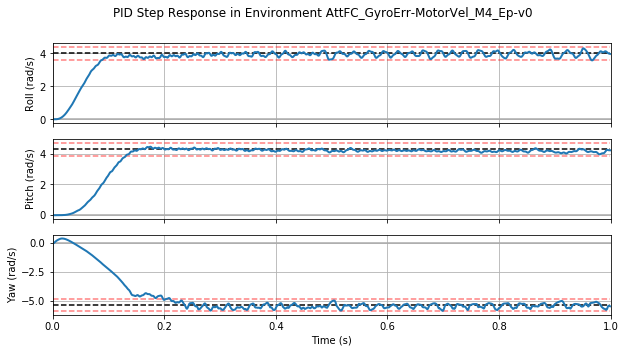

In [45]:
for s in range(15, 16):
    main(seed=s, verbose=True)

Starting gzserver with process ID= 26880


/home/ec2-user/.local/lib/python3.5/site-packages/ipykernel_launcher.py:205: RuntimeWarning: invalid value encountered in double_scalars



Tick #1
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 0. -0. -0.]
Is done: False
Reward: -0.7228548830855637


Tick #100
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 3.78063795  2.53462769 -2.17141945]
Is done: False
Reward: -0.2650513350050257


Tick #200
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 3.78913446  4.32482614 -4.88227193]
Is done: False
Reward: -0.03635236496981887


Tick #300
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 3.96817465  4.28226933 -5.63124986]
Is done: False
Reward: -0.016959793965127378


Tick #400
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 3.8473667   4.10776879 -5.38427883]
Is done: False
Reward: -0.016292753972304116


Tick #500
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 3.66917383  4.06694985 -4.96965228]
Is done: False
Reward: -0.04712047220105338


Tick #600
Need: [ 4.00404344  4.28262124 -5.33886072]
Right now: [ 4.10983146  4.15165245 -5.70144449]
Is done: False
Reward: -0.03

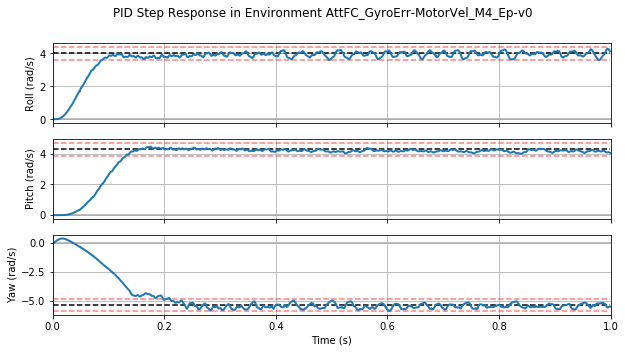

In [33]:
for s in range(15, 16):
    main(seed=s, verbose=True)